<a href="https://colab.research.google.com/github/MattRamb97/Erasmus_Hardgainers/blob/main/Recipes_model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RECIPES MODEL**

We utilized the URLs provided to access the datasets stored in the folder https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/

using the pandas library. Subsequently, we identified an issue in the 'ingredients' column of the three datasets, characterized by the presence of the word 'ADVERTISEMENT', which we proceeded to remove. Additionally, we printed information regarding one of the datasets (the same information applies to the others) and their respective shapes.

In [1]:
url_1 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_ar.json'

!pip install pandas
import pandas as pd
import sys
df_ar = pd.read_json(url_1, orient='records', dtype='dict').transpose()
df_ar.info()
print()

df_ar = df_ar.dropna(subset=['title', 'ingredients', 'instructions', 'picture_link'])

df_ar['title'] = df_ar['title'].astype(str)

df_ar['ingredients'] = df_ar['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)

# Safely evaluate the 'ingredients' column
def safe_eval(x):
    try:
        return ', '.join(eval(x))
    except:
        return ''  # Return an empty string in case of an error

df_ar['ingredients'] = df_ar['ingredients'].apply(safe_eval)

df_ar['instructions'] = df_ar['instructions'].astype(str)

print('From AR:', df_ar.shape)


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
<class 'pandas.core.frame.DataFrame'>
Index: 39802 entries, rmK12Uau.ntP510KeImX506H6Mr6jTu to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39522 non-null  object
 1   ingredients   39522 non-null  object
 2   instructions  39522 non-null  object
 3   picture_link  39522 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB

From AR: (39522, 4)


Cleaning of the ingredients from numbers, units of measure and ( , ) , /

In [2]:
import re

def clean_ingredients(ingredient):
    # Define the pattern to remove numbers, common units of measure, and unwanted characters including non-standard spaces
    pattern = r'\b\d+\.?\d*|\b(?:oz|ounce|ounces|lb|pound|pounds|g|gram|grams|kg|kilogram|kilograms|ml|milliliter|milliliters|l|liter|liters|tbsp|tbs|tablespoon|tablespoons|tsp|teaspoon|teaspoons|cup|cups|pinch|pinches)\b|[()\/]'
    # Replace the matched items with nothing (effectively removing them)
    cleaned_ingredient = re.sub(pattern, '', ingredient, flags=re.IGNORECASE)
    # Remove any kind of space-like characters and trim the string
    cleaned_ingredient = re.sub(r'\s+', ' ', cleaned_ingredient).strip()
    # Remove any invisible characters or non-breaking spaces
    cleaned_ingredient = re.sub(r'[\u200B-\u200D\uFEFF]', '', cleaned_ingredient)
    return cleaned_ingredient

# Apply the cleaning function to the ingredients column
df_ar['ingredients'] = df_ar['ingredients'].apply(clean_ingredients)

We cleaned the three datasets using two function:
- uncontract(): expands contracted words commonly found in English sentences into their full forms using regular expressions.
- clean_recepies(): removes non-alphanumeric characters from the input text except for spaces and hyphens. It then replaces multiple spaces and hyphens with a single space and normalizes units of measurement (e.g., cups, tablespoons) by removing them. Next, it removes numerical digits, assuming they represent quantities. Finally, it normalizes whitespace by removing extra spaces and ensuring consistent spacing between words.

In [3]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple/

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Create a formatting_func to structure training examples as prompts.

In [4]:
def formatting_func(ingredients, title, instructions):
    text = f"### Ingredients: {ingredients}\n### Generate Title and Instructions:\n### Title:{title}\n### Instructions: {instructions}"

    return text

Load Mistral - mistralai/Mistral-7B-v0.1

In [7]:
from huggingface_hub import notebook_login

notebook_login()
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"

# Load the model using the NVIDIA H100 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(base_model_id)
model.to(device)  # Move model to GPU

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

Set up the tokenizer. Add padding on the left as it makes training use less memory. For model_max_length, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(ingredients, title, instructions):
    return tokenizer(formatting_func(ingredients, title, instructions))

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Reformat the prompt and tokenize each sample

In [9]:
tokenized_titles = []
tokenized_ingredients = []
tokenized_instructions = []

for ingredients, title, instructions in zip(df_ar['ingredients'].iloc[:19761], df_ar['title'].iloc[:19761], df_ar['instructions'].iloc[:19761]):
    tokenized_ingredients.append(generate_and_tokenize_prompt( ingredients,title,instructions))
    tokenized_titles.append(generate_and_tokenize_prompt( ingredients,title, instructions))
    tokenized_instructions.append(generate_and_tokenize_prompt( ingredients,title, instructions))

Let's get a distribution of our dataset lengths, so we can determine the appropriate max_length for our input tensors.

39522


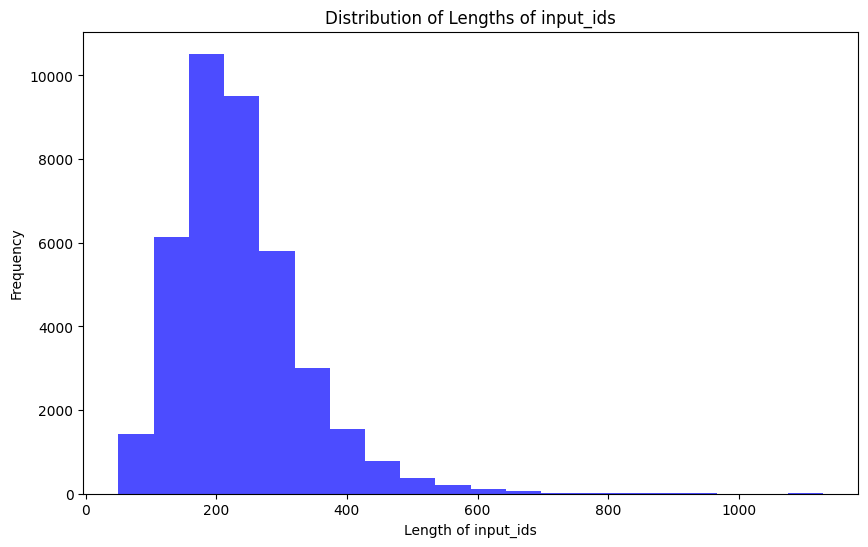

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_ingredients, tokenized_instructions):
    lengths = [len(x['input_ids']) for x in tokenized_titles]
    lengths += [len(x['input_ids']) for x in tokenized_ingredients]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_ingredients, tokenized_instructions)

In [12]:
max_length = 365  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(ingredients, title, instructions):

    ingredients_result = tokenizer(
        ingredients,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    title_result = tokenizer(
        title,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    instructions_result = tokenizer(
        instructions,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )

    ingredients_result["labels"] = ingredients_result["input_ids"].copy()
    title_result["labels"] = title_result["input_ids"].copy()
    instructions_result["labels"] = title_result["input_ids"].copy()

    return ingredients_result, title_result, instructions_result

# Tokenization of the dataset
tokenized_data = []
for ingredients, title, instructions in zip(df_ar['ingredients'].iloc[:19761], df_ar['title'].iloc[:19761], df_ar['instructions'].iloc[:19761]):
    ingredients_result, title_result, instructions_result = generate_and_tokenize_prompt2(ingredients, title, instructions)
    # Concatenating results into a single input
    combined_input_ids = ingredients_result["input_ids"] + title_result["input_ids"] + instructions_result["input_ids"]
    combined_labels = ingredients_result["labels"] + title_result["labels"] +  instructions_result["labels"]
    tokenized_data.append({'input_ids': combined_input_ids, 'labels': combined_labels})

# Split data into training and evaluation datasets
split_index = int(0.8 * len(tokenized_data))
train_dataset = tokenized_data[:split_index]
eval_dataset = tokenized_data[split_index:]

In [13]:
eval_prompt = f"### Ingredients: {df_ar['ingredients'].iloc[24367]}\n### Generate Title and Instructions:\n### Title:"

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Ingredients: brown sugar , sea salt , paprika , ground black pepper , onion powder , garlic powder , ground cumin , dried sage , crushed red pepper, or to taste , chili powder, or to taste , dried thyme, or to taste ,
### Generate Title and Instructions:
### Title: Brown Sugar Rubbed Pork Chops
### Instructions:
1. In a small bowl, mix together the brown sugar, sea salt, paprika, black pepper, onion powder, garlic powder, cumin, sage, red pepper flakes, chili powder, thyme, and oregano until well blended.
2. Place pork chops in a shallow dish and sprinkle both sides with rub mixture. Cover and refrigerate for at least 30 minutes.
3. Preheat an outdoor grill for medium-high heat and lightly oil the grate.
4. Grill pork chops for 5 to 7 minutes per side, or until no longer pink in the center and the juices run clear. An instant-read thermometer inserted into the center should read at least 145 degrees F (63 degrees C).




---



**Set Up LoRA**

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [14]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.

In [16]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

Here we define the LoRA config.

r is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

alpha is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were r=64 and lora_alpha=16, and these are said to generalize well, but we will use r=32 and lora_alpha=64 so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [17]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 7326773248 || trainable%: 1.1606903765339511


See how the model looks different now, with the LoRA adapters added:

In [18]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_f



---



**TRAINING LoRA MODEL**

In [19]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [20]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

model = accelerator.prepare_model(model)

In [21]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


wandb: Currently logged in as: matteo-rambaldi (recipes_model). Use `wandb login --relogin` to force relogin


In [22]:
import transformers
from transformers import TrainingArguments, Trainer
from datetime import datetime
import torch

project = "recepies-model_v4"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

# Initialize Trainer with your model and tokenizer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir='./output',
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False
trainer.train()

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.807500,1.262672
50,1.111900,1.117976
75,1.028800,1.087255
100,1.056900,1.067623
125,1.068800,1.052935
150,1.077500,1.040430
175,0.975000,1.031407
200,0.988100,1.023831
225,1.033700,1.019823
250,0.955600,1.013456


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 

TrainOutput(global_step=500, training_loss=1.13046875, metrics={'train_runtime': 6931.2566, 'train_samples_per_second': 0.144, 'train_steps_per_second': 0.072, 'total_flos': 4.727575719936e+16, 'train_loss': 1.13046875, 'epoch': 0.06325910931174089})

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"

# Load the model using the NVIDIA H100 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(base_model_id)
model.to(device)  # Move model to GPU

# Load tokenizer and configure with additional settings as needed
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)
'''
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)
'''

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

'\nbnb_config = BitsAndBytesConfig(\n    load_in_4bit=True,\n    bnb_4bit_use_double_quant=True,\n    bnb_4bit_quant_type="nf4",\n    bnb_4bit_compute_dtype=torch.bfloat16\n)\n\nbase_model = AutoModelForCausalLM.from_pretrained(\n    base_model_id,  # Mistral, same as before\n    quantization_config=bnb_config,  # Same quantization config as before\n    device_map="auto",\n    trust_remote_code=True,\n)\n\neval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)\n'

In [27]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, "output/checkpoint-475")

In [39]:
eval_prompt = f"### Ingredients: {df_ar['ingredients'].iloc[12369]}\n### Generate Title and Instructions:\n### Title:"

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    generated_texts = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
    print(generated_texts)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Ingredients: cooked chicken breasts, shredded , Granny Smith apples, cut into small chunks , chopped walnuts, or to taste , red onion, chopped , stalks celery, chopped , lemon juice , vanilla yogurt , creamy salad dressing such as Miracle Whip® , mayonnaise , seedless red grapes, halved ,
### Generate Title and Instructions:
### Title: Chicken Waldorf Salad
### Instructions:
1. In a large bowl, mix together the chicken, apple, walnuts, red onion, celery, lemon juice, yogurt, salad dressing, and mayonnaise until well blended. Gently stir in the grapes just before serving.
2. Refrigerate for at least 30 minutes before serving.
### Nutrition Information:
Calories: 459 calories;


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be

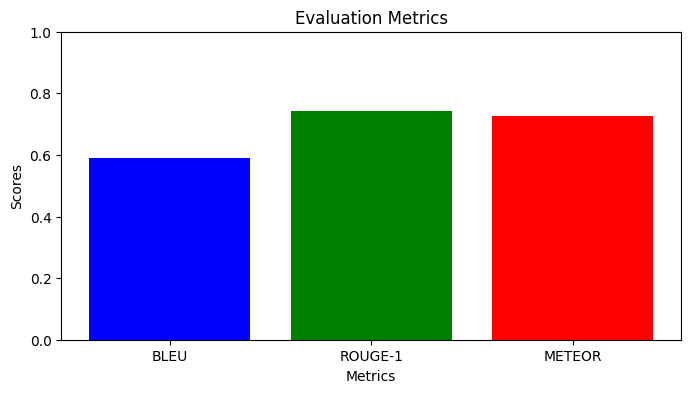

In [40]:
!pip install rouge_score
import matplotlib.pyplot as plt

def evaluate_and_plot(generated_text, reference_text):
    from datasets import load_metric
    bleu_metric = load_metric('bleu')
    rouge_metric = load_metric('rouge')
    meteor_metric = load_metric('meteor')

    predictions = [generated_text.split()]
    references = [[reference_text.split()]]

    # Compute metrics
    bleu_result = bleu_metric.compute(predictions=predictions, references=references)['bleu']
    rouge_result = rouge_metric.compute(predictions=[generated_text], references=[reference_text])['rouge1'].mid.fmeasure
    meteor_result = meteor_metric.compute(predictions=[generated_text], references=[reference_text])['meteor']

    # Prepare data for plotting
    metrics = ['BLEU', 'ROUGE-1', 'METEOR']
    scores = [bleu_result, rouge_result, meteor_result]

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.bar(metrics, scores, color=['blue', 'green', 'red'])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1)  # Assuming the scores are normalized between 0 and 1
    plt.show()

# Example generated and reference texts
reference_texts = f"### Ingredients: {df_ar['ingredients'].iloc[12369]}\n### Generate Title and Instructions:\n### Title:{df_ar['title'].iloc[12369]}\n### Instructions: {df_ar['instructions'].iloc[12369]}"

# Generate plot
evaluate_and_plot(generated_texts, reference_texts)